### Model Starter Document
- First resize image shapes to get data
- Next get blananced dataset across all defect types for training
- Test against balanced dataset and non-balanced dataset for testing
- KNN first and then if time NN

In [1]:
# Import Plotting Libaries
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt # plotting
%matplotlib inline
plt.style.use('ggplot')
from matplotlib import colors
from matplotlib import gridspec
from matplotlib.ticker import StrMethodFormatter
from matplotlib.ticker import MultipleLocator

# Import modeling libraries
import sklearn
sklearn.__version__
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from skimage.transform import resize as sk_resize

# Import Standard Libaries
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pickle5 as pickle
import time

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

In [2]:
with open('../WM-clean.pkl', "rb") as fh:
    data = pickle.load(fh)


In [3]:
data.head()

,waferMap,dieSize,lotName,waferIndex,failureType,encoding,x_,y_,shape,labels,dataset
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",test
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",test
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train


In [4]:
# Get most frequent die size and shapes
print(data.groupby('dieSize').size().sort_values(ascending=False))
print(data.groupby('shape').size().sort_values(ascending=False))

dieSize
516.0     16437
533.0     14350
776.0     12400
562.0     11252
518.0      9400
          ...  
3127.0        1
1397.0        1
1377.0        1
3203.0        1
3.0           1
Length: 645, dtype: int64
shape
(25, 27)    18781
(26, 26)    14366
(30, 34)    12400
(29, 26)    11751
(27, 25)    10682
            ...  
(71, 70)        1
(71, 63)        1
(42, 39)        1
(68, 75)        1
(15, 3)         1
Length: 346, dtype: int64


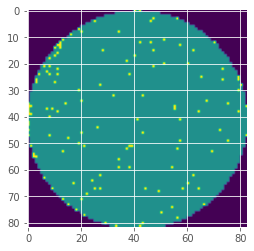

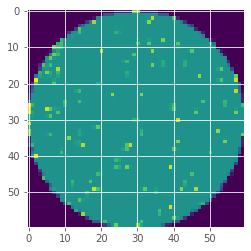

In [5]:
# example
#set resize dim variable - will use later
x_dim = 60
y_dim = 60

d12 = data[data['lotName'] == 'lot15471'].iloc[0].waferMap
d123 = sk_resize(d12*1024,[x_dim,y_dim], anti_aliasing=True)
plt.imshow(d12);
plt.show()
plt.imshow(d123);
plt.show()

In [6]:
# Build function to resize images
def resize_wafers(row):
    base_map = row['waferMap']
    resize_map = sk_resize(base_map*1024,[x_dim,y_dim], anti_aliasing=True)
    return resize_map

data['resize_waferMap'] = data.apply (lambda row: resize_wafers(row), axis=1)


In [7]:
# Add single label for model building

def label_wafer (row):
    string = ""
    if row['labels'][0] == 1:
        string += 'N'
    if row['labels'][1] == 1:
        string += 'ER'
    if row['labels'][2] == 1:
        string += 'EL'
    if row['labels'][3] == 1:
        string += 'C'
    if row['labels'][4] == 1:
        string += 'L'
    if row['labels'][5] == 1:
        string += 'S'
    if row['labels'][6] == 1:
        string += 'R'
    if row['labels'][7] == 1:
        string += 'D'
    if row['labels'][8] == 1:
        string += 'NF'
    if string == "":
        string = 'N'
    return string

def flat_map (row, map):
    return row[map].flatten()


data['wafer_label'] = data.apply (lambda row: label_wafer(row), axis=1)
data['flat_waferMap'] = data.apply (lambda row: flat_map(row, 'waferMap'), axis=1)
data['fr_waferMap'] = data.apply (lambda row: flat_map(row, 'resize_waferMap'), axis=1)
data.head()


,waferMap,dieSize,lotName,waferIndex,failureType,encoding,x_,y_,shape,labels,dataset,resize_waferMap,wafer_label,flat_waferMap,fr_waferMap
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",N,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",test,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",N,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",test,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",N,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",N,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",N,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [8]:
# Check out train, dev and test data sets
print(data.groupby('dataset').size().sort_values(ascending=False))

dataset
train    121065
test      25943
dev       25942
dtype: int64


In [9]:
# Check out by wafer_label
print(data.groupby('wafer_label').size().sort_values(ascending=False))

wafer_label
N     147431
ER      9680
EL      5189
C       4294
L       3593
S       1193
R        866
D        555
NF       149
dtype: int64


In [68]:
# Remove the "None" for testing
defect_df = data[data.wafer_label != 'N'].copy()
print(defect_df.groupby('wafer_label').size().sort_values(ascending=False))

wafer_label
ER    9680
EL    5189
C     4294
L     3593
S     1193
R      866
D      555
NF     149
dtype: int64


In [69]:
# Take a sample
# defect_df = defect_df.sample(frac=0.2, replace=True, random_state=1)
# print(defect_df.groupby('wafer_label').size().sort_values(ascending=False))

In [70]:
# encode labels
enc = sklearn.preprocessing.LabelEncoder()
enc_labels = enc.fit_transform(defect_df.wafer_label.to_numpy())
defect_df['encoded_wafer_label'] = enc_labels

In [71]:
# Build out test, train, dev datasets and labels for defect_df

# test_data    = np.stack(defect_df.loc[defect_df['dataset'] == 'test']['fr_waferMap'].to_numpy())
# test_labels  = defect_df.loc[defect_df['dataset'] == 'test']['wafer_label'].to_numpy()
# dev_data     = np.stack(defect_df.loc[defect_df['dataset'] == 'dev']['fr_waferMap'].to_numpy())
# dev_labels   = defect_df.loc[defect_df['dataset'] == 'dev']['wafer_label'].to_numpy()
# train_data   = np.stack(defect_df.loc[defect_df['dataset'] == 'train']['fr_waferMap'].to_numpy())
# train_labels = defect_df.loc[defect_df['dataset'] == 'train']['wafer_label'].to_numpy()

test_data    = np.stack(defect_df.loc[defect_df['dataset'] == 'test']['resize_waferMap'].to_numpy())
test_labels  = defect_df.loc[defect_df['dataset'] == 'test']['encoded_wafer_label'].to_numpy()
dev_data     = np.stack(defect_df.loc[defect_df['dataset'] == 'dev']['resize_waferMap'].to_numpy())
dev_labels   = defect_df.loc[defect_df['dataset'] == 'dev']['encoded_wafer_label'].to_numpy()
train_data   = np.stack(defect_df.loc[defect_df['dataset'] == 'train']['resize_waferMap'].to_numpy())
train_labels = defect_df.loc[defect_df['dataset'] == 'train']['encoded_wafer_label'].to_numpy()

In [72]:
# test_data = np.stack(test_data)
print('data shape: ', test_data.shape)
print('data 0 shape: ', test_data[0].shape)
print('label shape:', test_labels.shape)
print(type(test_data))
print(type(test_data[0]))
print(test_data[0])


data shape:  (3828, 60, 60)
data 0 shape:  (60, 60)
label shape: (3828,)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


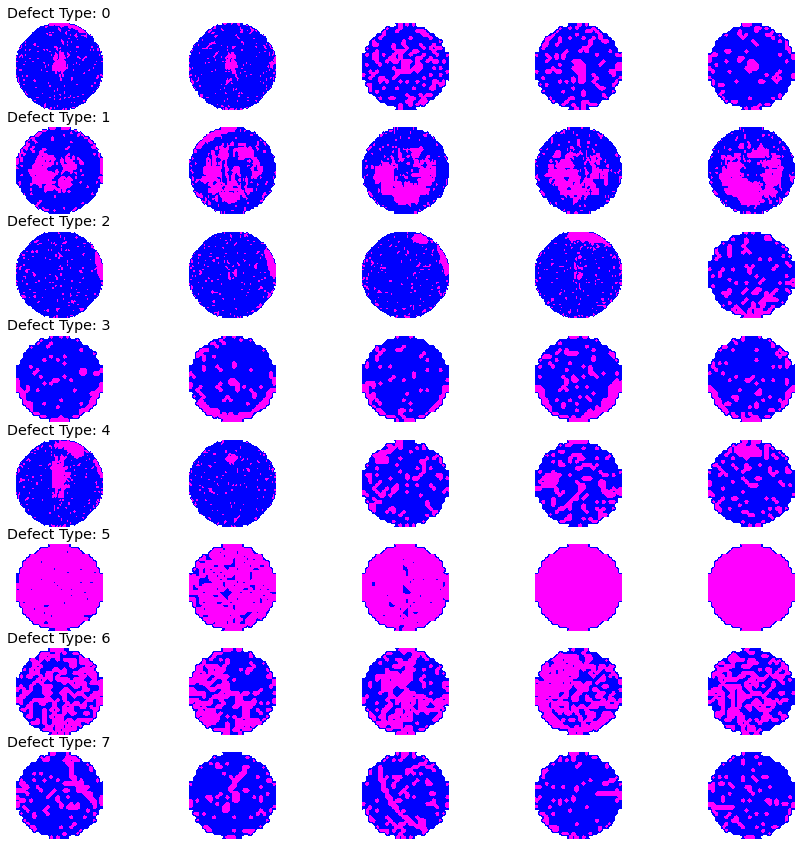

In [73]:
def show_wafermaps_types(num_examples=10):

### STUDENT START ###
    # Find unique digits, will be 0-9
    examples = np.unique(train_labels)   
    # Find the square dimentions of the X array for shaping for 2D Rendering, will be 28
#     dim = int(np.sqrt(mini_train_data.shape[1]))
#     dim=(25,27)
    dim=(x_dim, y_dim)

    # Set to Black and White
    # make a color map of fixed colors - blue passing die, yellow failing die
    cmap = colors.ListedColormap(['white', 'blue', 'fuchsia'])
    plt.rc('image', cmap=cmap)

    # Setup Figure Size and number of sub plots, examples sent into function and number of digits
    fig, axs = plt.subplots(len(examples), num_examples, figsize=(15, 15))

    # Nested for loops to loop through all digits and number of examples input for ploting
    for i,d in enumerate(examples):
        for j in range(num_examples):
            # reshape as 2D for rendering from dimensions above
            # imshow to plot image in axs i,j loaction in plot
            axs[i,j].imshow(train_data[train_labels==d][j].reshape(dim))
            axs[i,j].axis('off')

            if j == 0:
                axs[i, j].set_title(f'Defect Type: {d}')
            
show_wafermaps_types(5)

------------------------------------------------------------------------------
### CNN Model

In [17]:
import tensorflow as tf
from tensorflow import keras

In [119]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(8, (3, 3), activation='relu', input_shape= (60,60, 1)))
model.add(keras.layers.Conv2D(8, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Conv2D(16, (3, 3), activation='relu'))
model.add(keras.layers.Conv2D(16, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))

In [120]:
# Add Dense layers
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1028, activation='relu'))
model.add(keras.layers.Dense(1028, activation='relu'))
model.add(keras.layers.Dense(8, activation= 'softmax')) # num output classes

In [121]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_92 (Conv2D)          (None, 58, 58, 8)         80        
                                                                 
 conv2d_93 (Conv2D)          (None, 56, 56, 8)         584       
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 28, 28, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_94 (Conv2D)          (None, 26, 26, 16)        1168      
                                                                 
 conv2d_95 (Conv2D)          (None, 24, 24, 16)        2320      
                                                                 
 max_pooling2d_43 (MaxPoolin  (None, 12, 12, 16)       0         
 g2D)                                                

In [122]:
model.compile(optimizer= 'adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [123]:
epochs = 60
history = model.fit(train_data, train_labels, epochs=epochs, 
                    validation_data=(dev_data, dev_labels))

Epoch 1/60


/opt/anaconda3/envs/keras2/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


559/559 [==============================] - 17s 30ms/step - loss: 1.4007 - accuracy: 0.4753 - val_loss: 0.9299 - val_accuracy: 0.6489
Epoch 2/60
559/559 [==============================] - 16s 29ms/step - loss: 0.8077 - accuracy: 0.6976 - val_loss: 0.6445 - val_accuracy: 0.7584
Epoch 3/60
559/559 [==============================] - 17s 30ms/step - loss: 0.5561 - accuracy: 0.7901 - val_loss: 0.5797 - val_accuracy: 0.7782
Epoch 4/60
559/559 [==============================] - 17s 30ms/step - loss: 0.4687 - accuracy: 0.8247 - val_loss: 0.4105 - val_accuracy: 0.8420
Epoch 5/60
559/559 [==============================] - 17s 31ms/step - loss: 0.4091 - accuracy: 0.8464 - val_loss: 0.3854 - val_accuracy: 0.8524
Epoch 6/60
559/559 [==============================] - 17s 31ms/step - loss: 0.3741 - accuracy: 0.8566 - val_loss: 0.3635 - val_accuracy: 0.8592
Epoch 7/60
559/559 [==============================] - 17s 31ms/step - loss: 0.3464 - accuracy: 0.8692 - val_loss: 0.3696 - val_accuracy: 0.8621
Epo

In [114]:
epochs= 10
learning_rate = 0.1
momentum = 0.8

sgd = tf.keras.optimizers.SGD(
    learning_rate= learning_rate,
    momentum= 0.8,
    nesterov= False,
)
model.compile(optimizer= sgd,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [115]:
history = model.fit(train_data, train_labels, epochs=epochs, 
                    validation_data=(dev_data, dev_labels))

Epoch 1/60


/opt/anaconda3/envs/keras2/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


559/559 [==============================] - 15s 26ms/step - loss: 1.6535 - accuracy: 0.3785 - val_loss: 1.6424 - val_accuracy: 0.3793
Epoch 2/60
559/559 [==============================] - 16s 28ms/step - loss: 1.6438 - accuracy: 0.3793 - val_loss: 1.6442 - val_accuracy: 0.3793
Epoch 3/60
559/559 [==============================] - 15s 28ms/step - loss: 1.6436 - accuracy: 0.3793 - val_loss: 1.6414 - val_accuracy: 0.3793
Epoch 4/60
559/559 [==============================] - 15s 27ms/step - loss: 1.6430 - accuracy: 0.3793 - val_loss: 1.6452 - val_accuracy: 0.3793
Epoch 5/60
559/559 [==============================] - 16s 29ms/step - loss: 1.6428 - accuracy: 0.3793 - val_loss: 1.6410 - val_accuracy: 0.3793
Epoch 6/60
559/559 [==============================] - 16s 28ms/step - loss: 1.6422 - accuracy: 0.3793 - val_loss: 1.6405 - val_accuracy: 0.3793
Epoch 7/60
559/559 [==============================] - 16s 29ms/step - loss: 1.6427 - accuracy: 0.3793 - val_loss: 1.6431 - val_accuracy: 0.3793
Epo

KeyboardInterrupt: 

------------------------------------------------------------------------------
### Simple KNN Model

In [15]:
def KNN_Model(k_values):

### STUDENT START ###

    # Produce k-Nearest Neighbors models with k ∈  [1,3,5,7,9] (passed in)
    # Loop through all passed in k values
    for x in k_values:
        print (50*'-','\n','K-value:',x)
        
        model = KNeighborsClassifier(n_neighbors=x)
        model.fit(train_data, train_labels)
        test_predicted_labels = model.predict(dev_data)
        correct_prediction = (test_predicted_labels == dev_labels)
        wrong_prediction = (test_predicted_labels != dev_labels)
        model_score = model.score(dev_data, dev_labels)

        # Evaluate and show the accuracy of each model.
        print (' total: %3d  correct: %3d  accuracy: %.2f%%' 
               %((np.sum(correct_prediction)+np.sum(wrong_prediction)), 
                 np.sum(correct_prediction), model_score*100))   
              
        #For the 1-Nearest Neighbor model, additionally show the precision, recall, and F1 for each label
        if (x==1):
            print('\n', classification_report(dev_labels, test_predicted_labels))

            
### STUDENT END ###

k_values = [1, 3, 5, 7, 9]

KNN_Model(k_values)

-------------------------------------------------- 
 K-value: 1
 total: 3828  correct: 3164  accuracy: 82.65%

               precision    recall  f1-score   support

           C       0.82      0.95      0.88       637
           D       0.85      0.86      0.85        70
          EL       0.81      0.72      0.76       763
          ER       0.94      0.98      0.96      1471
           L       0.70      0.57      0.63       559
          NF       0.74      1.00      0.85        17
           R       0.94      0.71      0.81       117
           S       0.37      0.47      0.42       194

    accuracy                           0.83      3828
   macro avg       0.77      0.78      0.77      3828
weighted avg       0.83      0.83      0.82      3828

-------------------------------------------------- 
 K-value: 3
 total: 3828  correct: 3143  accuracy: 82.11%
-------------------------------------------------- 
 K-value: 5
 total: 3828  correct: 3107  accuracy: 81.17%
-----------------

 total: 3828  correct: 3191  accuracy: 83.36%


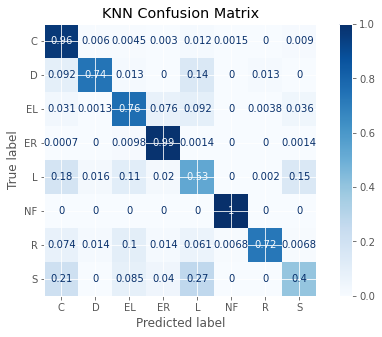

In [16]:
def KNN_model():

    # Find unique wafer patterns
    elements = np.unique(train_labels)
    
    # Build Model and Confusion Matrix
    model = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
    model.fit(train_data, train_labels)
    predicted_labels = model.predict(test_data)
    correct_prediction = (predicted_labels == test_labels)
    wrong_prediction = (predicted_labels != test_labels)
    model_score = model.score(test_data, test_labels)
    cm = confusion_matrix(test_labels, predicted_labels, labels=model.classes_)
    
    # Plot Confusion matrix and find top misclassifications 
    disp = plot_confusion_matrix(model, test_data, test_labels,
                                 display_labels= elements,
                                 cmap=plt.cm.Blues,
                                 normalize='true')
    disp.ax_.set_title('KNN Confusion Matrix')
    fig = plt.gcf()
    fig.set_size_inches(8,5)
    
    # Evaluate and show the accuracy of each model.
    print (' total: %3d  correct: %3d  accuracy: %.2f%%' 
           %((np.sum(correct_prediction)+np.sum(wrong_prediction)), 
              np.sum(correct_prediction), model_score*100))   
    

KNN_model()

------------------------------------------------------------------------------
### Try simple NN Model

In [17]:
## Create current best classifier
hidden_layer_sizes = tuple([100]*10)

# build classifier
classifier = MLPClassifier(hidden_layer_sizes = hidden_layer_sizes, 
                           early_stopping = True, alpha = 0.0001)

# fit classifier to training data
classifier.fit(train_data, train_labels)

# make predictions of test data
predictions = classifier.predict(test_data)

C:\Users\scott\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           C       0.96      0.90      0.93       670
           D       0.67      0.66      0.66        76
          EL       0.77      0.85      0.80       786
          ER       0.98      0.97      0.97      1434
           L       0.58      0.73      0.65       509
          NF       0.82      0.97      0.89        29
           R       0.74      0.78      0.76       148
           S       0.00      0.00      0.00       176

    accuracy                           0.84      3828
   macro avg       0.69      0.73      0.71      3828
weighted avg       0.82      0.84      0.83      3828



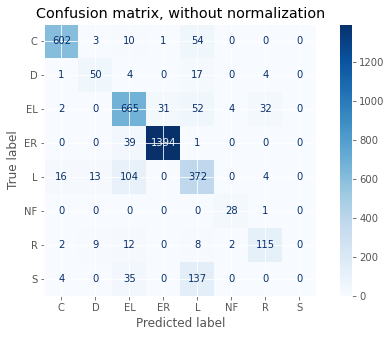

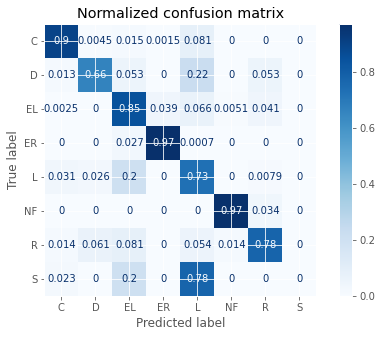

Overall accuracy: 84.27377220480669%


In [18]:
# generate and print classification report

# Find unique wafer patterns
elements = np.unique(train_labels)

print(classification_report(test_labels, predictions))

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
    disp = plot_confusion_matrix(classifier, test_data, test_labels,
                                 display_labels= elements,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)
    fig = plt.gcf()
    fig.set_size_inches(8,5)

plt.show()

# calculate and print accuracy
print("Overall accuracy: " + 
      str(100*metrics.accuracy_score(test_labels, predictions)) + "%")

In [19]:
# ## Use grid search to evaluate parameters

# # choose variables for grid search
# parameters = {"activation": ["identity", "logistic", "tanh", "relu"]}

# # build classifier
# classifier = GridSearchCV(MLPClassifier(hidden_layer_sizes = hidden_layer_sizes,
#                                         early_stopping = True), 
#                           param_grid = parameters, cv = 10, 
#                           scoring = "accuracy")

# # fit classifier to training data
# classifier.fit(train_data, train_labels)

# # make predictions of test data
# predictions = classifier.predict(test_data)

In [20]:
# print("Best parameters = ", classifier.best_params_)

# # calculate and print accuracy
# print("Best accuracy: " + 
#       str(100*metrics.accuracy_score(test_labels, predictions)) + "%")

In [21]:
## Use manual loop to evaluate parameters

# for activation in parameters["activation"]:
    
#     # build classifier
#     classifier = MLPClassifier(hidden_layer_sizes = hidden_layer_sizes,
#                                early_stopping = True, activation = activation)

#     # fit classifier to training data
#     classifier.fit(train_data, train_labels)

#     # make predictions of test data
#     predictions = classifier.predict(test_data)

#     print("Activation: " + activation)
#     # calculate and print accuracy
#     print("Accuracy: " + 
#       str(100*metrics.accuracy_score(test_labels, predictions)) + "%")